# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [1]:
# Сделаем необходимые импорты
import torch
import numpy as np

from torch import nn
from torch import optim
import torchvision

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn.functional as F

In [2]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10

train_dataset = torchvision.datasets.CIFAR100(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (label)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/
torch.Size([3, 32, 32])
19


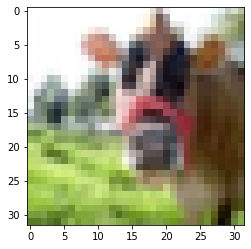

In [3]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

Files already downloaded and verified


In [5]:
classes_text = ('beaver, dolphin, otter, seal, whale, aquarium fish, flatfish, ray, shark, trout, orchids, poppies, roses, sunflowers, tulips, bottles, bowls, cans, cups, plates, apples, mushrooms, oranges, pears, sweet peppers, clock, computer keyboard, lamp, telephone, television, bed, chair, couch, table, wardrobe, bee, beetle, butterfly, caterpillar, cockroach, bear, leopard, lion, tiger, wolf, bridge, castle, house, road, skyscraper, cloud, forest, mountain, plain, sea, camel, cattle, chimpanzee, elephant, kangaroo, fox, porcupine, possum, raccoon, skunk, crab, lobster, snail, spider, worm, baby, boy, girl, man, woman, crocodile, dinosaur, lizard, snake, turtle, hamster, mouse, rabbit, shrew, squirrel, maple, oak, palm, pine, willow, bicycle, bus, motorcycle, pickup truck, train, lawn-mower, rocket, streetcar, tank, tractor')
classes = classes_text.split(', ')
len(classes), classes[2:6]

(100, ['otter', 'seal', 'whale', 'aquarium fish'])

In [9]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 8 * hidden_dim)
        self.fc2 = nn.Linear(8 * hidden_dim, 4 * hidden_dim)
        self.fc3 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc4 = nn.Linear(2 * hidden_dim, output_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.max_relu(x)
        x = self.fc2(x)
        x = self.max_relu(x)
        x = self.fc3(x)
        x = self.max_relu(x)
        x = self.fc4(x)
        x = self.max_relu(x)
        x = self.fc5(x)
        x = F.softmax(x)
        
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.max_relu(x)
        x = self.fc2(x)
        x = self.max_relu(x)
        x = self.fc3(x)
        x = self.max_relu(x)
        x = self.fc4(x)
        x = self.max_relu(x)
        x = self.fc5(x)
        x = F.softmax(x)

        return x

    def max_relu(self,x):
      return torch.maximum(F.leaky_relu(x, 0.1), F.leaky_relu(x, 0.5))

net = Net(3072, 100, 100)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
# Запустить обучение (по аналогии с тем, что делали на паре)

for epoch in tqdm(range(10)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,     1] loss: 0.002
[1,   301] loss: 0.691
[1,   601] loss: 0.691


 10%|█         | 1/10 [00:32<04:55, 32.87s/it]

[2,     1] loss: 0.002
[2,   301] loss: 0.691
[2,   601] loss: 0.691


 20%|██        | 2/10 [01:05<04:20, 32.61s/it]

[3,     1] loss: 0.002
[3,   301] loss: 0.691
[3,   601] loss: 0.691


 30%|███       | 3/10 [01:37<03:47, 32.56s/it]

[4,     1] loss: 0.002
[4,   301] loss: 0.691
[4,   601] loss: 0.691


 40%|████      | 4/10 [02:10<03:15, 32.65s/it]

[5,     1] loss: 0.002
[5,   301] loss: 0.691
[5,   601] loss: 0.691


 50%|█████     | 5/10 [02:42<02:41, 32.30s/it]

[6,     1] loss: 0.002
[6,   301] loss: 0.691
[6,   601] loss: 0.691


 60%|██████    | 6/10 [03:15<02:09, 32.46s/it]

[7,     1] loss: 0.002
[7,   301] loss: 0.691
[7,   601] loss: 0.691


 70%|███████   | 7/10 [03:46<01:36, 32.25s/it]

[8,     1] loss: 0.002
[8,   301] loss: 0.691
[8,   601] loss: 0.691


 80%|████████  | 8/10 [04:19<01:04, 32.39s/it]

[9,     1] loss: 0.002
[9,   301] loss: 0.691
[9,   601] loss: 0.691


 90%|█████████ | 9/10 [04:53<00:32, 32.84s/it]

[10,     1] loss: 0.002
[10,   301] loss: 0.691
[10,   601] loss: 0.691


100%|██████████| 10/10 [05:27<00:00, 32.78s/it]

Training is finished!
